In [1]:
# Import Dependencies
# from matplotlib import style
# style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# INSPECT
# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# Print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # Get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.station'>, <class 'sqlalchemy.ext.automap.measurement'>]


In [5]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [7]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

[('2017-08-23',)]

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
start_date = dt.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(results, columns=["Date", "Station", "Precipitation"])

# Sort the dataframe by date
prcp_df["Date"] = pd.to_datetime(prcp_df['Date'])
prcp_df = prcp_df.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Display the dataframe 
prcp_df.head()

,Date,Station,Precipitation
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02


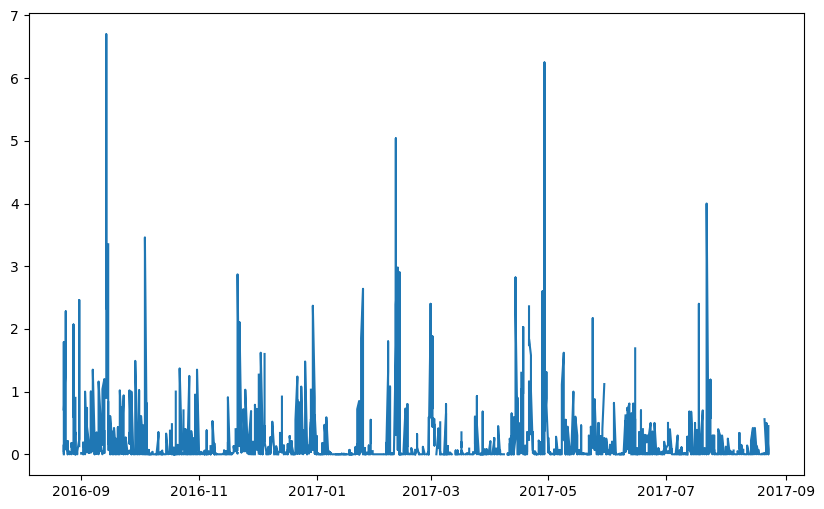

In [9]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(prcp_df.Date, prcp_df.Precipitation)
plt.show()

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.Precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all()

[(9,)]

In [12]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
station_df = pd.DataFrame(results, columns=["Station", "Observations"])
station_df.head()

,Station,Observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
most_active_station_df = pd.DataFrame(results, columns=["min_temp", "max_temp", "avg_temp"])
most_active_station_df.head()

,min_temp,max_temp,avg_temp
0,54.0,85.0,71.663781


In [14]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station

# Calculate the date one year from the last date in data set.
start_date = dt.date(2016, 8, 23)

# Perform a query to retrieve the data and tobs scores
results = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
most_active_station_df = pd.DataFrame(results, columns=["Date", "Station", "TOBS"])

# Sort the dataframe by date
most_active_station_df["Date"] = pd.to_datetime(most_active_station_df['Date'])
most_active_station_df = most_active_station_df.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Display the dataframe 
most_active_station_df.head()

,Date,Station,TOBS
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


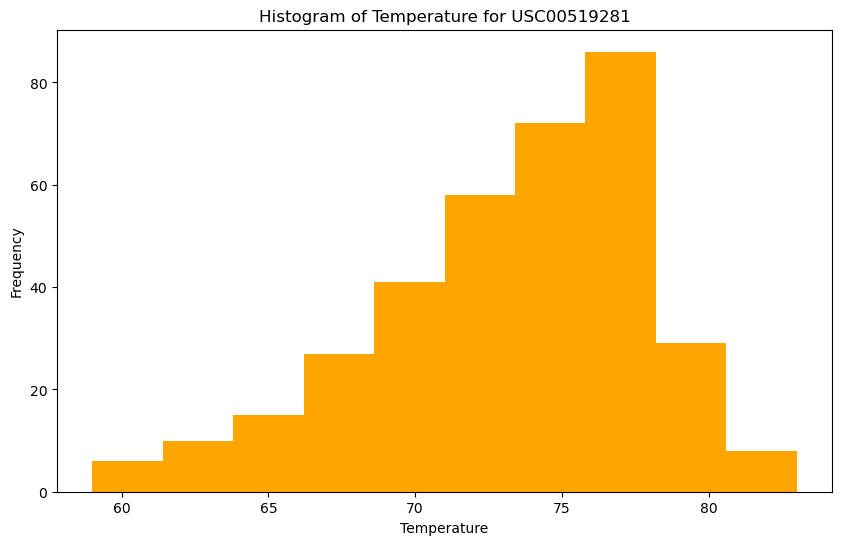

In [15]:
# Plot the results as a histogram
plt.figure(figsize=(10,6))
plt.hist(most_active_station_df.TOBS, color="orange")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Histogram of Temperature for USC00519281")
plt.show()

# Close Session

In [16]:
# Close Session
session.close()
